In [1]:
import pandas as pd
import json
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import random
import gensim
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Word2Vec
from sklearn.svm import SVC
import torch
import torch.utils.data as Data
import torchvision

In [2]:
path = "dataset/"
df = pd.read_csv(path+"USvideos.csv")
df = df.assign(country="US")
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')  
df.trending_date = df.trending_date.dt.date   
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df=df.assign(publish_date=df['publish_time'].dt.date)
df['publish_time'] = df['publish_time'].dt.time

###导入category名称###
df=df.assign(cat_name='a')
id_to_category = {}
file=path+'US_category_id.json'
with open(file, 'r') as f:
    data=json.load(f)
    for category in data['items']:
        id_to_category[category['id']] = category['snippet']['title']
print(id_to_category)
###实际上每个国家的category id-name 字典是一样的
df['category_id'] = df['category_id'].astype(str)
df.insert(4, 'category', df['category_id'].map(id_to_category))

{'1': 'Film & Animation', '2': 'Autos & Vehicles', '10': 'Music', '15': 'Pets & Animals', '17': 'Sports', '18': 'Short Movies', '19': 'Travel & Events', '20': 'Gaming', '21': 'Videoblogging', '22': 'People & Blogs', '23': 'Comedy', '24': 'Entertainment', '25': 'News & Politics', '26': 'Howto & Style', '27': 'Education', '28': 'Science & Technology', '29': 'Nonprofits & Activism', '30': 'Movies', '31': 'Anime/Animation', '32': 'Action/Adventure', '33': 'Classics', '34': 'Comedy', '35': 'Documentary', '36': 'Drama', '37': 'Family', '38': 'Foreign', '39': 'Horror', '40': 'Sci-Fi/Fantasy', '41': 'Thriller', '42': 'Shorts', '43': 'Shows', '44': 'Trailers'}


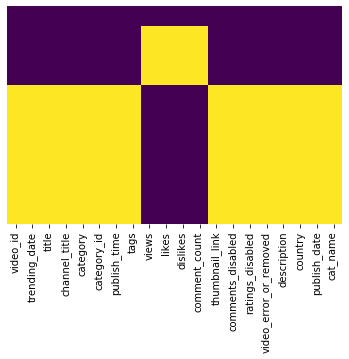

In [3]:
df_summary = df.describe(include="all")

# Use heatmap to check missing data
sb.heatmap(df_summary.isnull(), yticklabels=False, cbar=False, cmap='viridis')

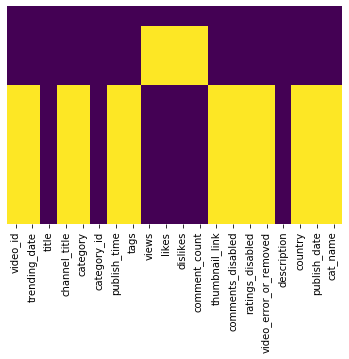

In [4]:
df.sample(5)
# Replace missing data
df_summary['description'].fillna("", inplace=True)
df_summary['title'].fillna("", inplace=True)
df_summary['category_id'].fillna(0, inplace=True)

# Drop a column most value are missing
# df_summary.drop(['thumbnail_link'], axis=1, inplace=True)
sb.heatmap(df_summary.isnull(), yticklabels=False, cbar=False, cmap='viridis')

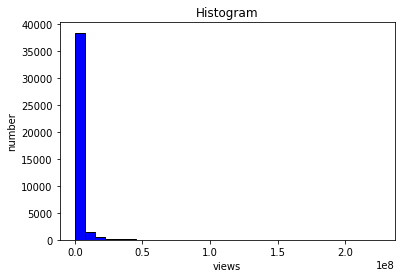

In [5]:
# normalize
# Import the libraries

# plt.plot(df['views'],df['view'])
# matplotlib histogram
plt.hist(df['views'], color = 'blue', edgecolor = 'black',
         bins = int(30))

# # seaborn histogram
# sb.distplot(df['view'], hist=True, kde=False, 
#              bins=int(180/5), color = 'blue',
#              hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram')
plt.xlabel('views')
plt.ylabel('number')

# np.sum(df['views']>2.35e6)
y_train = np.zeros_like(df['views'])
# y_train[df['views']>7e5] = 1
y_train[df['views']>2.35e6] = 1
# y_train.shape
# np.median(df['views'])

In [6]:
y_train[:100]
df['description'][:10]

0    SHANTELL'S CHANNEL - https://www.youtube.com/s...
1    One year after the presidential election, John...
2    WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3    Today we find out if Link is a Nickelback amat...
4    I know it's been a while since we did this sho...
5    Using the iPhone for the past two weeks -- her...
6    Embattled Alabama Senate candidate Roy Moore (...
7    Ice Cream Pint Combination Lock - http://amzn....
8    Inspired by the imagination of P.T. Barnum, Th...
9    For now, at least, we have better things to wo...
Name: description, dtype: object

In [100]:
from string import punctuation
import re
print(punctuation)

# get rid of punctuation
# l = list(df['description'])
# reviews = df['description'].values.tolist().lower() # lowercase, standardize
# print(reviews)
reviews=[str(tmp).lower() for tmp in df['description']]
all_text = []
for r in reviews:
    tmp = r.split(' ')
    tmp_text = [c for c in tmp if c not in punctuation and c not in ['--','---'] and re.match('http', c)==None]
#     print(len(tmp))
    tmp = ' '.join(tmp_text)
    tmp = tmp.replace("\\n"," ")
    tmp.replace("鈥?","? ")
    tmp.replace("鈥檛","'t")
    tmp.replace("ci贸","tio")
    tmp.replace("茅","e")
    tmp.replace("鈥檚","'s")
    tmp.replace("鈥淭","t")
    tmp.replace("鈥淢","m")

    tmp.replace("鈥淲","w")
    tmp.replace("鉃?"," ")
    tmp.replace("鈥楾","t")
    tmp.replace("鈥楥","c")

    tmp.replace("鈥檝","'r")
    tmp.replace("鈥楩","f")
    tmp.replace("鈫揊","F")
    all_text.append(tmp)

# all_text = [c for c in all_text if c not in punctuation]
# import re
# all_text = [c for c in reviews if re.match('http', c).span()]
print(len(all_text))
all_text

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
40949


["shantell's channel this video in 4k on this this lens drone gear camera camera; lens; sony camera; canon camera; tripod thing; need this for the bendy tripod; lens; expensive wide lens; camera; microphone; drone (cheaper but still great);http://tinyurl.com/zcfmnmd  follow me; on intro song by disclosure. this is not an ad. not selling or promoting anything. but samsung did produce the shantell video as a 'galaxy project' which is an initiative that enables creators like shantell and me to make projects we might otherwise not have the opportunity to make. hope that's clear. if not ask in the comments and i'll answer any specifics.",
 "one year after the presidential election, john oliver discusses what we've learned so far and enlists our catheter cowboy to teach donald trump what he hasn't.  connect with last week tonight online...  subscribe to the last week tonight youtube channel for more almost news as it almost happens: www.youtube.com/user/lastweektonight  find last week tonigh

In [98]:

# split by new lines and spaces

reviews_split = all_text#.split('\n')
all_text = ' '.join(reviews_split)
print(len(reviews_split))
# create a list of words
words = all_text.split()

40949


In [99]:

words[:30]

["shantell's",
 'channel',
 'https://www.youtube.com/shantellmartin',
 'candice',
 'https://www.lovebilly.com',
 'filmed',
 'this',
 'video',
 'in',
 '4k',
 'on',
 'this',
 'http://amzn.to/2stdnrz',
 'with',
 'this',
 'lens',
 'http://amzn.to/2rujomd',
 'big',
 'drone',
 'http://tinyurl.com/h4ft3oy',
 'other',
 'gear',
 'http://amzn.to/2o3glx5',
 'sony',
 'camera',
 'http://amzn.to/2nobmnv',
 'old',
 'camera;',
 'http://amzn.to/2o2cqbt',
 'main']

In [48]:
from collections import Counter

## Build a dictionary that maps words to integers
count = Counter(words)
vocab = sorted(count,key=count.get,reverse=True)
vocab_to_int = {word:i for i,word in enumerate(vocab,1)}

## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
reviews_ints = []
for review in reviews_split:
    tmp = []
    for word in review.split():
        tmp.append(vocab_to_int[word])
    reviews_ints.append(tmp)
print(len(reviews_ints))

40949


In [49]:
# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))  # should ~ 74000+
print()

print(np.array(reviews_ints).shape)
# print tokens in first review
print('Tokenized review: \n', reviews_ints[0][:10])

Unique words:  87641

(40949,)
Tokenized review: 
 [45798, 66, 14, 27, 8, 1873, 4, 14, 14, 753]


In [50]:

# 1=positive, 0=negative label conversion
encoded_labels = y_train
print(encoded_labels[:20])

[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [51]:
# outlier review stats
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 104
Maximum review length: 786


In [52]:
print('Number of reviews before removing outliers: ', len(reviews_ints))

## remove any reviews/labels with zero length from the reviews_ints list.
review_nonzero_idx = [i  for i,review in enumerate(reviews_ints) if(len(review)!=0)]

reviews_ints = [reviews_ints[i] for i in review_nonzero_idx]
encoded_labels = [encoded_labels[i] for i in review_nonzero_idx]

print('Number of reviews after removing outliers: ', len(reviews_ints))

Number of reviews before removing outliers:  40949
Number of reviews after removing outliers:  40845


In [53]:
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    ## implement function
    features = np.zeros((len(reviews_ints),seq_length),dtype=np.int32)
    
    for i in range(len(reviews_ints)):
#         print(i)
        features[i,-len(reviews_ints[i]):] = reviews_ints[i][:seq_length]
    
    return features

In [54]:

# Test your implementation!

seq_length = 150

features = pad_features(reviews_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches 
print(features[:30,:10])

[[    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    7  1337    17 41763    29    40   501   153     3  9526]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [  170    29    93  1475     7    28  2428     7    67     6]
 [    0     0     0     0     0     0     0     0     0

In [55]:

split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)
encoded_labels = np.array(encoded_labels)


length = len(features)
split = int(split_frac*length)

train_x,valid_x = features[:split],features[split:]
train_y,valid_y = encoded_labels[:split],encoded_labels[split:]

test_x,test_y = valid_x[len(valid_x)//2:],valid_y[len(valid_y)//2:]
valid_x,valid_y = valid_x[:len(valid_x)//2],valid_y[:len(valid_y)//2]
## print out the shapes of your resultant feature data
print('Train set : ',train_x.shape,train_y.shape)
print('Validation set : ',valid_x.shape,valid_y.shape)
print('Test set : ',test_x.shape,test_y.shape)

Train set :  (32676, 150) (32676,)
Validation set :  (4084, 150) (4084,)
Test set :  (4085, 150) (4085,)


In [56]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x).type(torch.LongTensor), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x).type(torch.LongTensor), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x).type(torch.LongTensor), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [57]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 150])
Sample input: 
 tensor([[    0,     0,     0,  ...,    57,   442,  4169],
        [    0,     0,     0,  ...,    37,     4,   155],
        [    0,     0,     0,  ...,  9484,  2433, 10630],
        ...,
        [    0,     0,     0,  ...,   507,   922,   703],
        [    0,     0,     0,  ...,   353,     2,  1934],
        [    0,     0,     0,  ...,   875,   127, 45802]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0])


In [58]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [89]:

import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embed = nn.Embedding(vocab_size,embedding_dim)
        self.embed.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,n_layers,dropout=drop_prob,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_size)
        self.sigmoid = nn.Sigmoid()
        self.drp = nn.Dropout(p=0.7)

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size=x.shape[0]
        
        x = self.embed(x)
#         print(hidden.shape)
       
        x,hidden = self.lstm(x,hidden)
        
        x = x.reshape(-1,self.hidden_dim)
        
        x = self.drp(x)
        
        x = self.fc(x)
        
        sig_out = self.sigmoid(x)
        
        # return last sigmoid output and hidden state
        sig_out = sig_out.reshape(batch_size,-1)
        sig_out = sig_out[:,-1]
        
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        
        return hidden

In [90]:

# Instantiate the model w/ hyperparams
vocab_size = len(vocab)+1
output_size = 1
embedding_dim = 8
hidden_dim = 16
n_layers = 2

net = None
net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embed): Embedding(87642, 8)
  (lstm): LSTM(8, 16, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (drp): Dropout(p=0.7, inplace=False)
)


In [93]:

# loss and optimization functions
lr=0.00001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [94]:
# training params
validLoss,trainLoss = [],[]
epochs = 10 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping
minValidLoss = np.inf #use for saving model whenever valid loss becomes less than min valid loss

# move model to GPU, if available
device = 'cuda' if(torch.cuda.is_available()) else 'cpu'
net.to(device)
print("Running on",device)

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    print()
    for batch,(inputs, labels) in enumerate(train_loader,1):
        print(f'\rBatch : {batch}/{len(train_loader)}',end='')
        counter += 1
        
        if(train_on_gpu):
            inputs, labels = inputs.cuda().long(), labels.cuda().long()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
    else:
        # Get validation loss
        print()
        val_h = net.init_hidden(batch_size)
        val_losses = []
        net.eval()
        for inputs, labels in valid_loader:

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            val_h = tuple([each.data for each in val_h])

            if(train_on_gpu):
                inputs, labels = inputs.cuda().long(), labels.cuda().long()

            output, val_h = net(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

        net.train()
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.6f}...".format(loss.item()),
              "Val Loss: {:.6f}".format(np.mean(val_losses)))
        
        if(np.mean(val_losses)<minValidLoss):
          print('\t\t...Saving Model...')
          torch.save(net.state_dict(),'LSTM_Model.pt')
          minValidLoss = np.mean(val_losses)
          
        trainLoss.append(loss.item())
        validLoss.append(np.mean(val_losses))

Running on cpu

Batch : 653/653
Epoch: 1/10... Step: 653... Loss: 0.702903... Val Loss: 0.698721
		...Saving Model...

Batch : 653/653
Epoch: 2/10... Step: 1306... Loss: 0.685460... Val Loss: 0.691504
		...Saving Model...

Batch : 653/653
Epoch: 3/10... Step: 1959... Loss: 0.662699... Val Loss: 0.683876
		...Saving Model...

Batch : 653/653
Epoch: 4/10... Step: 2612... Loss: 0.635143... Val Loss: 0.675611
		...Saving Model...

Batch : 653/653
Epoch: 5/10... Step: 3265... Loss: 0.616651... Val Loss: 0.665862
		...Saving Model...

Batch : 653/653
Epoch: 6/10... Step: 3918... Loss: 0.553346... Val Loss: 0.656428
		...Saving Model...

Batch : 653/653
Epoch: 7/10... Step: 4571... Loss: 0.554461... Val Loss: 0.653054
		...Saving Model...

Batch : 653/653
Epoch: 8/10... Step: 5224... Loss: 0.615745... Val Loss: 0.663780

Batch : 653/653
Epoch: 9/10... Step: 5877... Loss: 0.448776... Val Loss: 0.676256

Batch : 653/653
Epoch: 10/10... Step: 6530... Loss: 0.540802... Val Loss: 0.690514


In [ ]:
import matplotlib.pyplot as plt
plt.plot(trainLoss,color='g')
plt.plot(validLoss,color='b')
plt.show()

In [75]:
#Loading saved model
net.load_state_dict(torch.load('LSTM_Model.pt'))

if(train_on_gpu):
  net.to('cuda')
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda().long(), labels.cuda().long()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.694
Test accuracy: 0.559


In [69]:
# negative test review
test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'

In [70]:
import string
def predict(net, test_review, sequence_length=200):
  ''' Prints out whether a give review is predicted to be 
  positive or negative in sentiment, using a trained model.

  params:
  net - A trained net 
  test_review - a review made of normal text and punctuation
  sequence_length - the padded length of a review
  '''
  test_review = ''.join([ch for ch in test_review if ch not in string.punctuation])
  encoded_words = [vocab_to_int[word] for word in test_review.split() if(vocab_to_int.get(word,False)>0)]
  
  features = pad_features(np.array(encoded_words).reshape(1,-1),sequence_length)
  features = torch.Tensor(features)
  
  net.to('cpu')
  
  hidden = net.init_hidden(1)
  output,h = net(features.long(),(hidden[0].cpu(),hidden[1].cpu()))
  
  # print custom response based on whether test_review is pos/neg
  print('Positive' if output>0.5 else 'Negative')
  
  
predict(net,test_review_neg)

Negative


In [71]:

# positive test review
test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'

In [72]:
# call function
# try negative and positive reviews!
seq_length=200
predict(net, test_review_pos, seq_length)

Negative
